In [ ]:
# These modules are commonly used in Python and are part of the standard library.
import json, time, urllib.parse

#"The 'requests' module is not included in the Python standard library by default. If you don't already have it installed, you can install it using pip or pip3."
import requests

Importing necessary libraries.

*   pandas: Data manipulation and analysis library.
*   numpy: Numerical computing library for efficient array operations.
*   matplotlib.pyplot: Library for creating data visualizations.








In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2023040100"    # this is likely the wrong end date
}


Reading an Excel file into a Pandas DataFrame


In [ ]:
# Creating a list of articles we are interested in analysing
article_df = pd.read_excel('/content/drive/My Drive/DATA_512_HW_1/thank_the_academy.AUG.2023.csv.xlsx')


In [ ]:
article_df.head(10)

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...
5,Avatar: The Way of Water,https://en.wikipedia.org/wiki/Avatar:_The_Way_...
6,Women Talking (film),https://en.wikipedia.org/wiki/Women_Talking_(f...
7,Guillermo del Toro's Pinocchio,https://en.wikipedia.org/wiki/Guillermo_del_To...
8,Navalny (film),https://en.wikipedia.org/wiki/Navalny_(film)
9,The Elephant Whisperers,https://en.wikipedia.org/wiki/The_Elephant_Whi...


The code exports a 'name' column from a DataFrame to a CSV file, converts it into a list, replaces spaces with underscores in each title, and prints the number of articles considered for analysis

In [ ]:
article_df['name'].to_csv('/content/drive/My Drive/DATA_512_HW_1/intermediate_files/articles_list.csv')
ARTICLE_TITLES = article_df['name'].to_list()
ARTICLE_TITLES = [title.replace(' ', '_') for title in ARTICLE_TITLES]
print(f'No. of wikipedia articles considered for analysis: {len(ARTICLE_TITLES)}')

No. of wikipedia articles considered for analysis: 1359


This function requests pageviews data for a specified article title and access type (desktop or mobile) from an API. It takes the article title, access type, API endpoint details, and headers as input parameters. The function returns a JSON object containing the pageviews for the article. It also handles URL encoding, API request throttling, and error handling

In [ ]:
def request_pageviews_per_article(article_title = None,
                                  access_type = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    """
    It takes an article title and an access type (desktop or mobile),
    and returns a JSON object containing the pageviews for that article
    @param article_title - the title of the article to request pageviews for
    @param access_type - the type of access to the article, either desktop or mobile
    @param endpoint_url - the URL for the API endpoint
    @param endpoint_params - the parameters for the request, which are the same for all requests
    @param request_template - this is a dictionary that contains the parameters for the request.
    @param headers - the headers for the request, which are required by the API
    @returns A JSON object with the pageviews for the article
    """
    # Make sure we have an article title
    if not article_title or not access_type: return None

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    request_template['access'] = access_type

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    print(request_url)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

# **1 Data** **Acquistion**

The `fetch_data` function retrieves pageviews data for a list of article titles, separates it into mobile and desktop views, and saves the results as JSON files. It involves the following steps:

- Initialize result lists for mobile, desktop, and cumulative views.
- Loop through article titles and make API requests for each access type.
- Handle API request errors and print error messages.
- Extract and combine pageviews data from API responses.
- Append data to respective result lists.
- Save the collected data as JSON files.
- Uncomment the last line to execute the data acquisition process.

In [ ]:
def fetch_data():
    """
    Fetches and combines pageviews data for a list of article titles, separates it into mobile and desktop views,
    and saves the results in JSON files.
    """
    # Initialize result lists
    mobile_results = []
    desktop_results = []
    cumulative_results = []

    for article_title in ARTICLE_TITLES:
        try:
            # Make API requests for each access type
            mobile_app_response = request_pageviews_per_article(article_title, 'mobile-app')
            mobile_web_response = request_pageviews_per_article(article_title, 'mobile-web')
            desktop_response = request_pageviews_per_article(article_title, 'desktop')
            cumulative_response = request_pageviews_per_article(article_title, 'all-access')

            # Check for API request errors
            if None in (mobile_app_response, mobile_web_response, desktop_response, cumulative_response):
                print(f"Skipping article '{article_title}' due to API request error.")
                continue

            # Extract 'items' data from responses
            mobile_app_views = mobile_app_response['items']
            mobile_web_views = mobile_web_response['items']
            desktop_views = desktop_response['items']
            cumulative_views = cumulative_response['items']

            # Combine mobile-app and mobile-web views
            mobile_views = []
            for app_view, web_view in zip(mobile_app_views, mobile_web_views):
                mobile_view = app_view
                mobile_view['views'] += web_view['views']
                del mobile_view['access']
                mobile_views.append(mobile_view)

            # Append results to respective lists
            mobile_results.extend(mobile_views)
            desktop_results.extend(desktop_views)
            cumulative_results.extend(cumulative_views)

        except Exception as error:
            print(f"Error processing article '{article_title}': {str(error)}")
            continue

    # Save results to JSON files
    save_to_json(mobile_results, '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_mobile_start201507-end203210.json')
    save_to_json(desktop_results, '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_desktop_start201507-end203210.json')
    save_to_json(cumulative_results, '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_cumulative_start201507-end203210.json')

# Uncomment the below line to download a fresh copy of JSON files containing the article view data
# fetch_data()

def save_to_json(data, file_path):
    """
    Saves the provided data to a JSON file at the specified file path.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file)


Streaming output truncated to the last 5000 lines.
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-app/user/The_Big_Short_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-web/user/The_Big_Short_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/The_Big_Short_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/The_Big_Short_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-app/user/The_Danish_Girl_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-web/user/The_Danish_Girl_%28film%29/monthly/2015010100/2023040100
https://wikimedia.org/api/rest_v1/me

- Description: Reads a JSON file into a Pandas DataFrame, converts the timestamp column to a datetime object, and returns the DataFrame.
- Parameters:
  - `file_path` (str): The file path to the JSON file.
- Returns:
  - A Pandas DataFrame.

In [39]:
def read_json_to_dataframe(file_path):
    """
    Reads a JSON file into a Pandas DataFrame, converts the timestamp column to a datetime object, and returns the DataFrame.
    @param file_path: The file path to the JSON file.
    @return: A DataFrame.
    """
    # Read JSON data into a DataFrame, specifying the timestamp column as a string data type.
    dataframe = pd.read_json(file_path, convert_dates=False, dtype={'timestamp': pd.StringDtype})

    # Convert the 'timestamp' column to a datetime object with the specified format.
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format='%Y%m%d%H')

    return dataframe

# Define file paths for JSON and CSV data.
json_mobile_path = '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_mobile_start201507-end203210.json'
json_desktop_path = '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_desktop_start201507-end203210.json'
json_cumulative_path = '/content/drive/My Drive/DATA_512_HW_1/JSON_data/academy_monthly_cumulative_start201507-end203210.json'

csv_mobile_path = '/content/drive/My Drive/DATA_512_HW_1/CSV_data/academy_monthly_mobile_start201507-end203210.csv'
csv_desktop_path = '/content/drive/My Drive/DATA_512_HW_1/CSV_data/academy_monthly_desktop_start201507-end203210.csv'
csv_cumulative_path = '/content/drive/My Drive/DATA_512_HW_1/CSV_data/academy_monthly_cumulative_start201507-end203210.csv'

# Read JSON files into DataFrames and convert/save them as CSV files.
mobile_dataframe = read_json_to_dataframe(json_mobile_path)
desktop_dataframe = read_json_to_dataframe(json_desktop_path)
cumulative_dataframe = read_json_to_dataframe(json_cumulative_path)

# Save DataFrames as CSV files at the specified paths.
mobile_dataframe.to_csv(csv_mobile_path, index=False)
desktop_dataframe.to_csv(csv_desktop_path, index=False)
cumulative_dataframe.to_csv(csv_cumulative_path, index=False)


 **2.1. Figure showing Maximum Average and Minimum Average articles text**

get_max_min_avg_articles(dataframe): This function takes a DataFrame with article views data, calculates the mean views for each article, and returns DataFrames for articles with the maximum and minimum average views.

article_grouped = dataframe.groupby('article')['views'].mean().reset_index(): Within the function, the DataFrame is grouped by the 'article' column, and mean views are calculated.

max_df and min_df: These DataFrames contain articles with the highest and lowest average views, respectively.

In [31]:
def get_max_min_avg_articles(dataframe):
    """
    It takes a dataframe as input, groups the dataframe by article, then finds the mean of the views for each article. It
    then finds the index of the max and min values of the views column, and returns the rows of the dataframe that
    correspond to the max and min values.
    @param df - the dataframe
    @returns the dataframe of the article with the maximum views and the dataframe of the article with the minimum views.
    """
    article_grouped = dataframe.groupby('article')['views'].mean().reset_index()
    max_view_article = article_grouped.loc[article_grouped['views'].idxmax()]['article']
    min_view_article = article_grouped.loc[article_grouped['views'].idxmin()]['article']

    max_df = dataframe[dataframe['article'] == max_view_article]
    min_df = dataframe[dataframe['article'] == min_view_article]

    return max_df, min_df


mob_max_df, mob_min_df = get_max_min_avg_articles(mobile_dataframe)
desk_max_df, desk_min_df = get_max_min_avg_articles(desktop_dataframe)

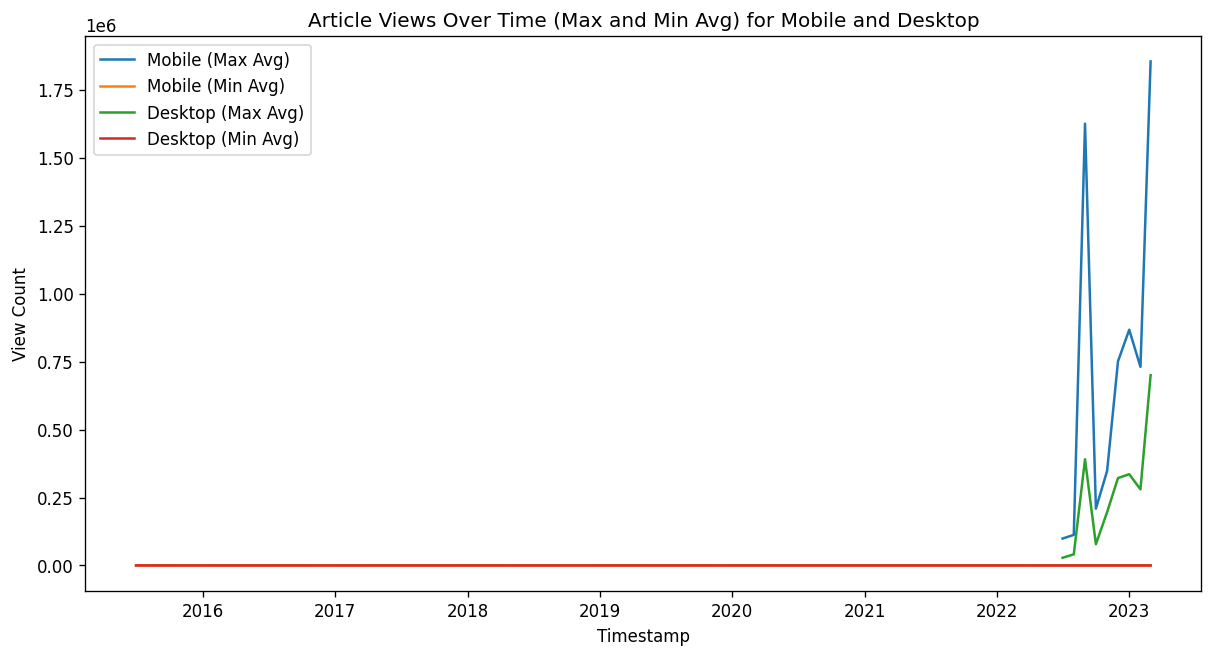

In [34]:
def plot_line(df, label):
    """
    Plots the views over time for the given DataFrame and labels the plot.
    @param df: The DataFrame to plot.
    @param label: The label for the plot.
    """
    plt.plot(df['timestamp'], df['views'], label=label)

plt.figure(figsize=(12, 6), dpi=120)

# Define labels and legends for the plot
labels = ['Mobile (Max Avg)', 'Mobile (Min Avg)', 'Desktop (Max Avg)', 'Desktop (Min Avg)']

# Plot lines and add labels
plot_line(mob_max_df, labels[0])
plot_line(mob_min_df, labels[1])
plot_line(desk_max_df, labels[2])
plot_line(desk_min_df, labels[3])

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Article Views Over Time (Max and Min Avg) for Mobile and Desktop')
plt.legend(labels, prop={'size': 10}, loc='upper left')

# Save the plot with a different name
plt.savefig('/content/drive/My Drive/DATA_512_HW_1/figures/max_min_viewed_articles.png')

# Show the plot
plt.show()


**2.2. Showing Top 10 Peak Page Views**

This code identifies the top 10 articles with the highest peak page views for both mobile and desktop access, and it generates corresponding line plots for visual analysis.

In [41]:
def get_top_10(df):
    """
    The function performs the below operations,
    1. Group the dataframe by article and get the max views for each article.
    2. Sort the dataframe by views in descending order.
    3. Get the top 10 articles.
    4. Return the top 10 articles and the dataframe with only the top 10 articles.
    @param df - the dataframe
    @returns The top 10 articles and the dataframe with only the top 10 articles
    """
    df_grpd = df.groupby(['article'], as_index=False).max('views').sort_values(by=['views'], ascending=False).iloc[:10]
    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

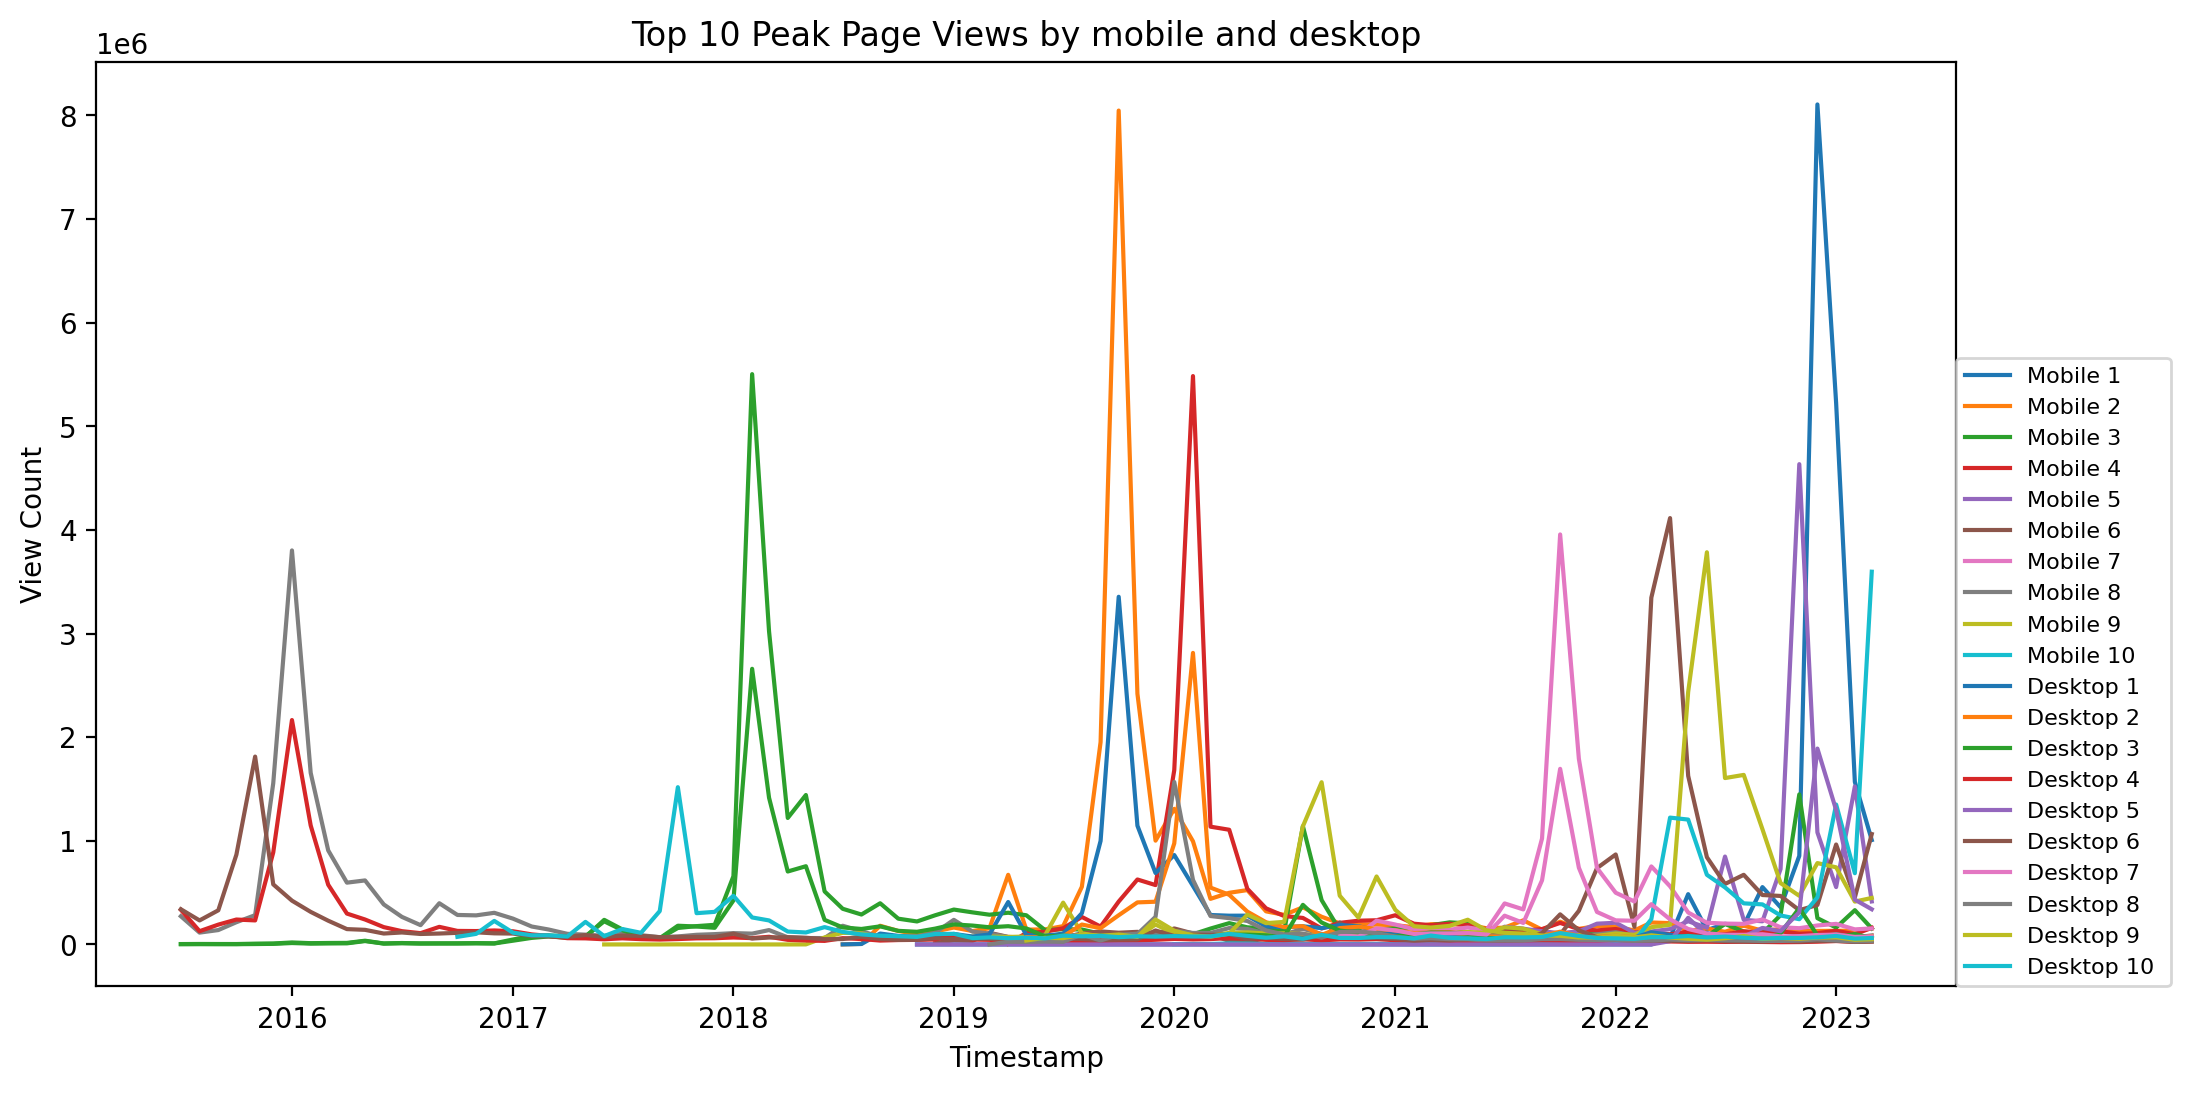

In [47]:
mobile_top10, mobile_top10_df = get_top_10(mobile_dataframe)
desktop_top10, desktop_top10_df = get_top_10(desktop_dataframe)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_top10):
    plot_line(mobile_top10_df[mobile_top10_df['article'] == article], f'Mobile {idx+1} ')


for idx, article in enumerate(desktop_top10):
    plot_line(desktop_top10_df[desktop_top10_df['article'] == article], f'Desktop {idx+1} ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Top 10 Peak Page Views by mobile and desktop')
plt.legend(prop={'size': 8}, loc=(1, 0))
plt.savefig('/content/drive/My Drive/DATA_512_HW_1/figures/top_10_most_viewed_articles.png')

**2.3 Figure showing articles with fewest months of Data**

This code identifies the top 10 articles with the least number of views per month for both mobile and desktop access and generates corresponding line plots for visual analysis.

In [ ]:
def articles_by_least_view_months(df):
    """
    It returns the top 10 articles that have the least number of views per month
    @param df - the dataframe
    @returns A tuple of two dataframes.
    """
    df_grpd = df[['article', 'views']]\
                .groupby(['article'], as_index=False)\
                .count()\
                .sort_values(by=['views'])\
                .iloc[:10]\
                .rename(columns={'views': 'count'})

    return df_grpd['article'], df[df['article'].isin(df_grpd['article'].to_list())]

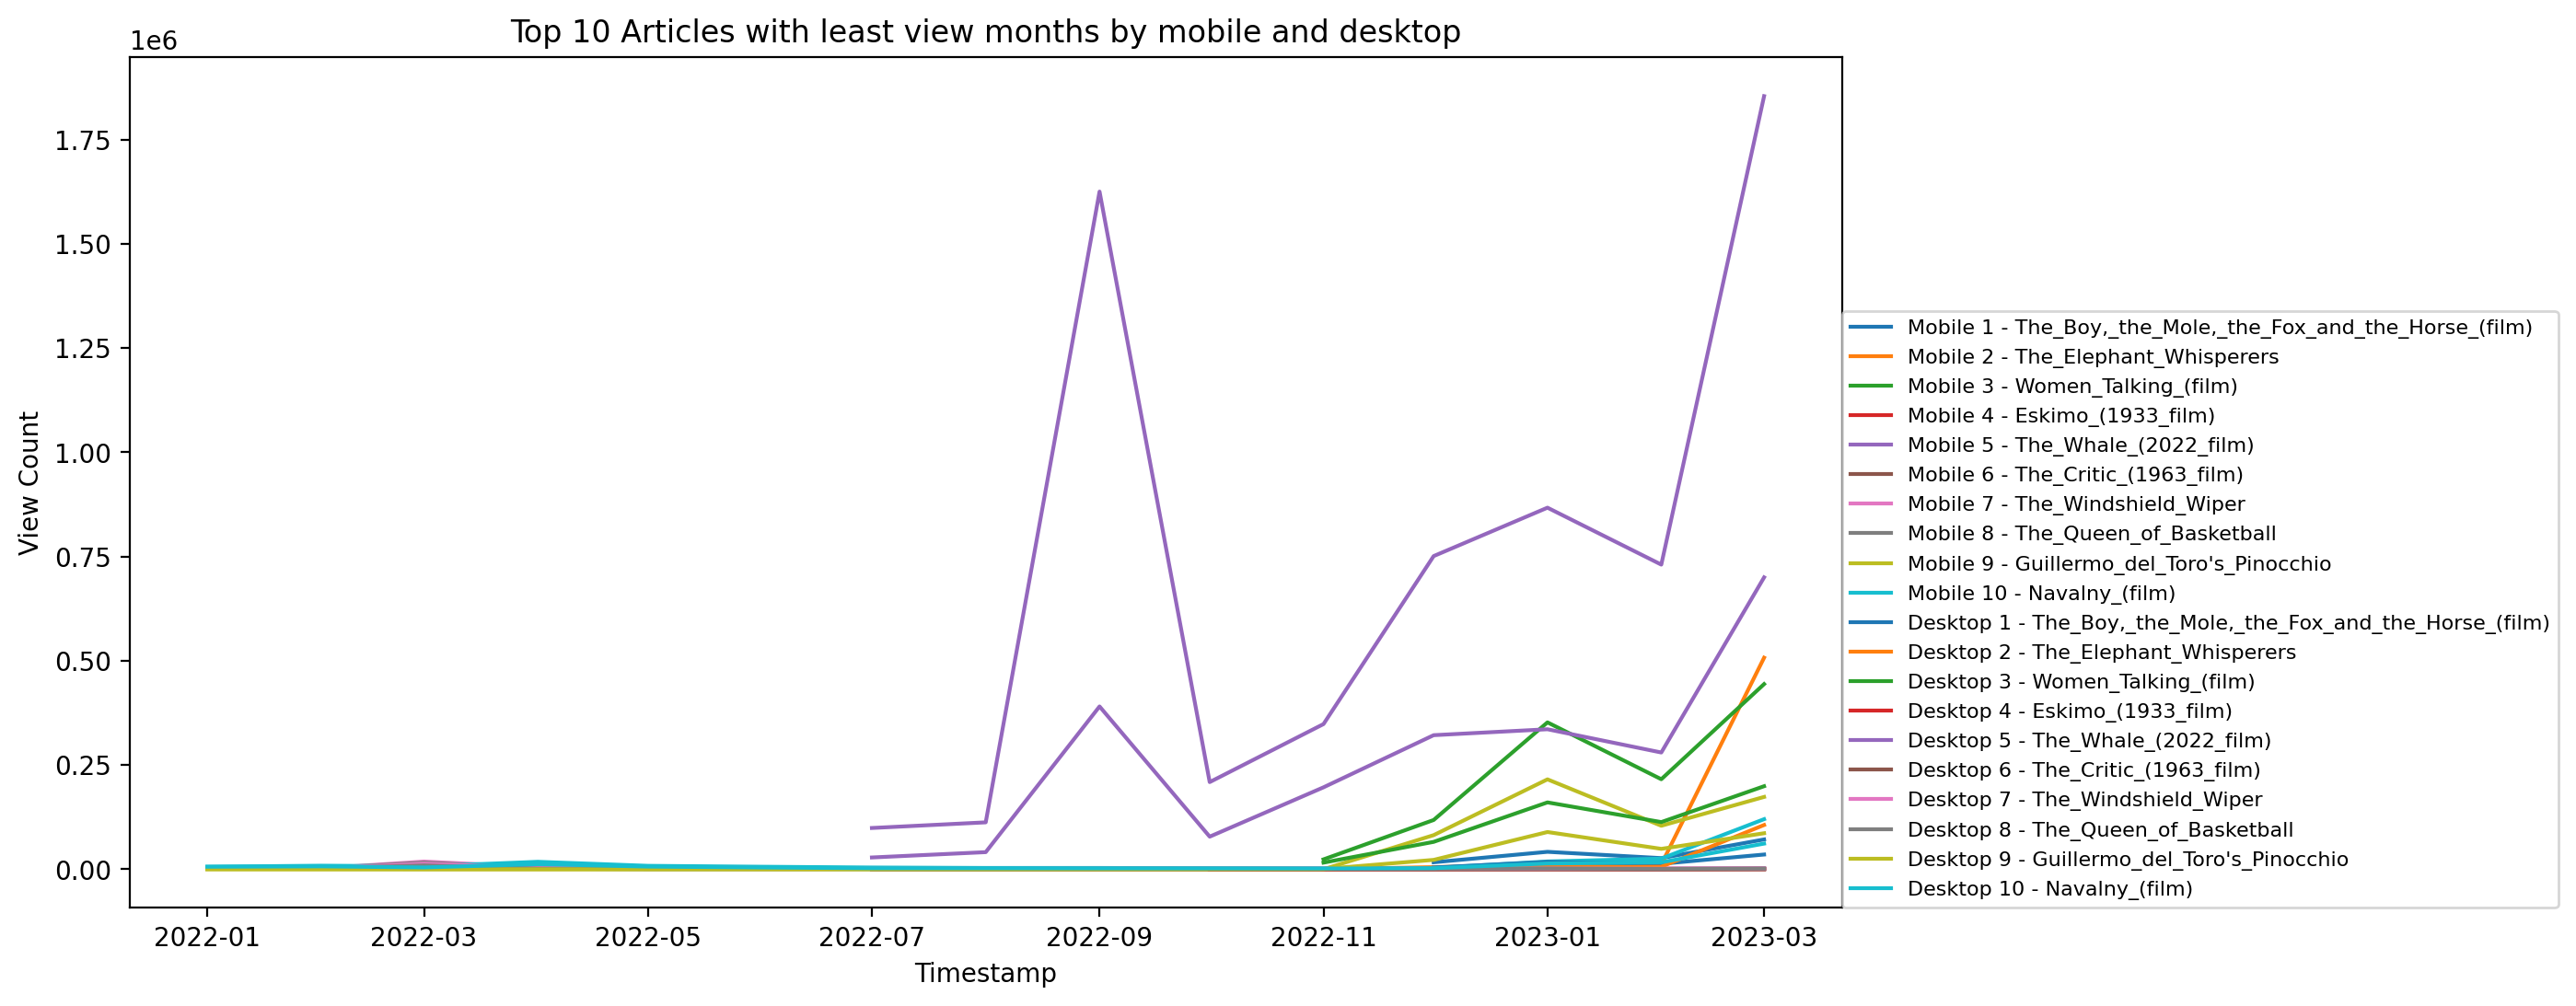

In [ ]:
mobile_least, mobile_least_df = articles_by_least_view_months(mobile_dataframe)
desktop_least, desktop_least_df = articles_by_least_view_months(desktop_dataframe)

plt.figure(figsize=(12, 6), dpi=200)
for idx, article in enumerate(mobile_least):
    plot_line(mobile_least_df[mobile_least_df['article'] == article], f'Mobile {idx+1} - ')


for idx, article in enumerate(desktop_least):
    plot_line(desktop_least_df[desktop_least_df['article'] == article], f'Desktop {idx+1} - ')

plt.xlabel('Timestamp')
plt.ylabel('View Count')
plt.title('Top 10 Articles with least view months by mobile and desktop')
plt.legend(prop={'size': 8}, loc=(1, 0))
plt.savefig('/content/drive/My Drive/DATA_512_HW_1/figures/least_view_month_articles.png')